In [26]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
os.environ['KERAS_BACKEND']='theano' # Why theano why not
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline

In [27]:
#Upload the Dataset
from google.colab import files
uploaded = files.upload()

Saving Clean_data_1.csv to Clean_data_1 (1).csv


In [28]:
# Dataset is now stored in a Pandas Dataframe
import io
data = pd.read_csv(io.BytesIO(uploaded['Clean_data_1.csv']))

In [29]:
data.head()

,Unnamed: 0,Hotel_id,Hotel,Address,City,Title,Users,Reviews,Rating,User_id,Sentiment,Label,Text_Clean,lemmatized,polarity,token,review_length
0,0,0,La Quinta,5820 Walden Rd,Beaumont,This hotel is a dump! Upon ch...,margierodriguez.mcqueen,This hotel is a dump! Upon checking in was tol...,1,15400,Negative,0,this hotel is a dump upon checking in was told...,hotel dump check tell place book folk run isaa...,0.188788,"['this', 'hotel', 'is', 'a', 'dump', 'upon', '...",209
1,1,1,The Point,Po Box 1327,Saranac Lake,Great family time,motomomMaryland,The point is possibly one of our favorite rest...,5,15740,Positive,1,the point is possibly one of our favorite rest...,point possibly favorite restaurant child age f...,0.350000,"['the', 'point', 'is', 'possibly', 'one', 'of'...",60
2,2,1,The Point,Po Box 1327,Saranac Lake,Throw back to the Gatsby Era - don't miss The ...,ellen00007,From the minute you arrive until the minute yo...,5,13760,Positive,1,from the minute you arrive until the minute yo...,minute arrive minute sadly leave point treat p...,0.233333,"['from', 'the', 'minute', 'you', 'arrive', 'un...",67
3,3,1,The Point,Po Box 1327,Saranac Lake,The Point of it all,Szerzek,That is the name on one of their boats. And th...,5,11027,Positive,1,that is the name on one of their boats and the...,boat essence philosophy get point right warm c...,0.372857,"['that', 'is', 'the', 'name', 'on', 'one', 'of...",66
4,4,1,The Point,Po Box 1327,Saranac Lake,The most amazing week end!,Sarahbnyc83,I was lucky enough to spend 2 nights at The Po...,5,10306,Positive,1,i was lucky enough to spend nights at the poin...,lucky spend night point year february dream pl...,-0.043434,"['i', 'was', 'lucky', 'enough', 'to', 'spend',...",65


In [30]:
# Checking for missing values
pd.isnull(data).any()

Unnamed: 0       False
Hotel_id         False
Hotel            False
Address          False
City             False
Title            False
Users            False
Reviews          False
Rating           False
User_id          False
Sentiment        False
Label            False
Text_Clean        True
lemmatized        True
polarity         False
token            False
review_length    False
dtype: bool

In [31]:
data = data.dropna()
data = data.reset_index(drop=True)
print('Shape of dataset ',data.shape)
print(data.columns)
print('No. of unique classes',len(set(data['Sentiment'])))

Shape of dataset  (10002, 17)
Index(['Unnamed: 0', 'Hotel_id', 'Hotel', 'Address', 'City', 'Title', 'Users',
       'Reviews', 'Rating', 'User_id', 'Sentiment', 'Label', 'Text_Clean',
       'lemmatized', 'polarity', 'token', 'review_length'],
      dtype='object')
No. of unique classes 2


In [32]:
def clean_str(string):
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string

In [33]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.25

In [34]:
macronum=sorted(set(data['Label']))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))

def fun(i):
    return macro_to_id[i]

data['Label']=data['Label'].apply(fun)

In [35]:
texts = []
labels = []


for idx in range(data.Text_Clean.shape[0]):
    text = BeautifulSoup(data.Text_Clean[idx])
    texts.append(clean_str(str(text.get_text().encode())))

for idx in data['Label']:
    labels.append(idx)

In [36]:

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Number of Unique Tokens',len(word_index))

Number of Unique Tokens 23725


In [37]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of Data Tensor:', data.shape)
print('Shape of Label Tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

Shape of Data Tensor: (10002, 1000)
Shape of Label Tensor: (10002, 2)


In [38]:
!wget http://nlp.stanford.edu/data/glove.6B.zip


--2020-10-15 07:51:09--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-10-15 07:51:09--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-10-15 07:51:10--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

In [39]:
!unzip glove*.zip


Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: glove.6B.50d.txt        
replace glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: glove.6B.100d.txt       
replace glove.6B.200d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: glove.6B.200d.txt       
replace glove.6B.300d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: glove.6B.300d.txt       


In [40]:
!ls
!pwd

 accuracy_cnn.png	 glove.6B.100d.txt   glove.6B.zip     sample_data
'Clean_data_1 (1).csv'	 glove.6B.200d.txt   glove.6B.zip.1
 Clean_data_1.csv	 glove.6B.300d.txt   loss_cnn.png
 cnn_model.png		 glove.6B.50d.txt    model_cnn.hdf5
/content


In [48]:
print('Indexing word vectors.')

embeddings_index = {}
f = open('glove.6B.300d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 300d..' % len(embeddings_index))

Indexing word vectors.
Total 400000 word vectors in Glove 6B 300d..


In [42]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,trainable=True)

In [43]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5)(l_cov2)
l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(len(macronum), activation='softmax')(l_dense)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("Simplified convolutional neural network")
model.summary()
cp=ModelCheckpoint('model_cnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)


Simplified convolutional neural network
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 300)         7117800   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 996, 128)          192128    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_5 (Conv

In [44]:
history=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=7, batch_size=32,callbacks=[cp])


Epoch 1/7
235/235 [==============================] - ETA: 0s - loss: 0.4805 - acc: 0.7870
Epoch 00001: val_acc improved from -inf to 0.86560, saving model to model_cnn.hdf5
235/235 [==============================] - 246s 1s/step - loss: 0.4805 - acc: 0.7870 - val_loss: 0.3455 - val_acc: 0.8656
Epoch 2/7
235/235 [==============================] - ETA: 0s - loss: 0.3259 - acc: 0.8692
Epoch 00002: val_acc did not improve from 0.86560
235/235 [==============================] - 243s 1s/step - loss: 0.3259 - acc: 0.8692 - val_loss: 0.3375 - val_acc: 0.8588
Epoch 3/7
235/235 [==============================] - ETA: 0s - loss: 0.2574 - acc: 0.8978
Epoch 00003: val_acc improved from 0.86560 to 0.88040, saving model to model_cnn.hdf5
235/235 [==============================] - 237s 1s/step - loss: 0.2574 - acc: 0.8978 - val_loss: 0.3095 - val_acc: 0.8804
Epoch 4/7
235/235 [==============================] - ETA: 0s - loss: 0.1803 - acc: 0.9312
Epoch 00004: val_acc improved from 0.88040 to 0.88160, 

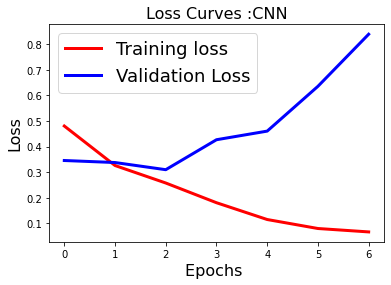

In [45]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('loss_cnn.png')
plt.show()

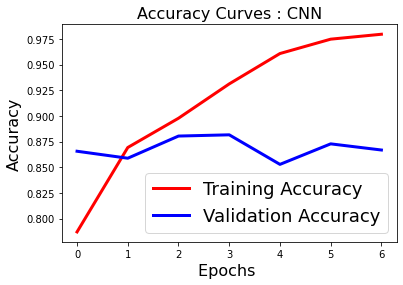

In [46]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig2.savefig('accuracy_cnn.png')
plt.show()

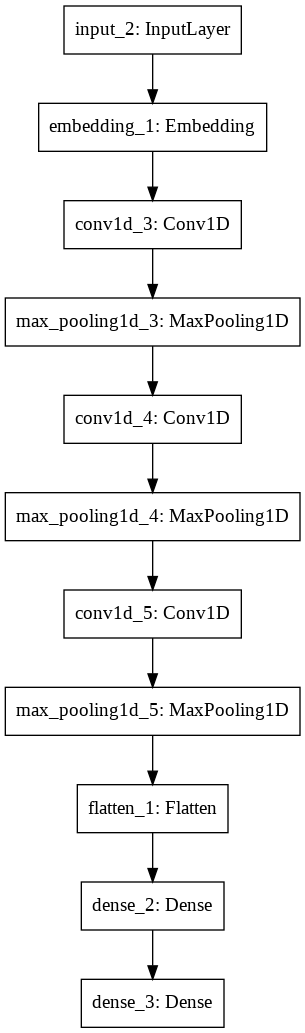

In [47]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='cnn_model.png')